In [1]:
# Daniel Bandala Alvarez @ feb 2022
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split,learning_curve
from sklearn import metrics
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,RocCurveDisplay,auc
# classifiers models
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# COVID Classifier
Machine learning (ML) based methods have shown unprecedented success in the reliable analysis of medical diagnostic. ML-based approaches are scalable, automatable, and easy to implement in clinical settings. A common application of ML-based image analysis is the classification of images with highly similar features. In the other hand, Coronavirus disease (COVID-19) is an infectious disease caused by the SARS-CoV-2 virus. Most people infected with the virus will experience mild to moderate respiratory illness and recover without requiring special treatment. However, some will become seriously ill and require medical attention. Older people and those with underlying medical conditions like cardiovascular disease, diabetes, chronic respiratory disease, or cancer are more likely to develop serious illness. Anyone can get sick with COVID-19 and become seriously ill or die at any age.

In this work, we build three classifiers model for the task of COVID cases classification. The importance for each variable is presented when it is used Random Forest Classifier, then we use the most significant variables for the classification task and train a multilayer perceptron model. Moreover, the best approach to estimate a confirmed COVID case is using a Decision Trees model.

## Read data

In [2]:
# script parameters
separator = ','
filename = "220528COVID19MEXICO.csv"
chunksize = 10 ** 5
# trainning and validation files names
train_file = '220528COVID19MEXICO_TRAIN.csv'
test_file = '220528COVID19MEXICO_TEST.csv'

In [3]:
# read file by chunks
with pd.read_csv(filename, chunksize=chunksize, sep=separator) as reader:
    data = reader.get_chunk()

In [4]:
# iterating the columns
print("VARIABLES AND ITS TYPE\n-------------------------")
for col in data.columns:
    print(col,' -> ',data[col].dtype)

VARIABLES AND ITS TYPE
-------------------------
FECHA_ACTUALIZACION  ->  object
ID_REGISTRO  ->  object
ORIGEN  ->  int64
SECTOR  ->  int64
ENTIDAD_UM  ->  int64
SEXO  ->  int64
ENTIDAD_NAC  ->  int64
ENTIDAD_RES  ->  int64
MUNICIPIO_RES  ->  int64
TIPO_PACIENTE  ->  int64
FECHA_INGRESO  ->  object
FECHA_SINTOMAS  ->  object
FECHA_DEF  ->  object
INTUBADO  ->  int64
NEUMONIA  ->  int64
EDAD  ->  int64
NACIONALIDAD  ->  int64
EMBARAZO  ->  int64
HABLA_LENGUA_INDIG  ->  int64
INDIGENA  ->  int64
DIABETES  ->  int64
EPOC  ->  int64
ASMA  ->  int64
INMUSUPR  ->  int64
HIPERTENSION  ->  int64
OTRA_COM  ->  int64
CARDIOVASCULAR  ->  int64
OBESIDAD  ->  int64
RENAL_CRONICA  ->  int64
TABAQUISMO  ->  int64
OTRO_CASO  ->  int64
TOMA_MUESTRA_LAB  ->  int64
RESULTADO_LAB  ->  int64
TOMA_MUESTRA_ANTIGENO  ->  int64
RESULTADO_ANTIGENO  ->  int64
CLASIFICACION_FINAL  ->  int64
MIGRANTE  ->  int64
PAIS_NACIONALIDAD  ->  object
PAIS_ORIGEN  ->  object
UCI  ->  int64


In [5]:
# remove a priori non-causal parameters
proc_data = data.drop(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'CLASIFICACION_FINAL'], axis=1)
# encode non numerical data
for col in proc_data.columns:
    if proc_data[col].dtype!='int64':
        proc_data[col] = LabelEncoder().fit_transform(proc_data[col])
# get correlation in the independent variables
cor_matrix = data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

/tmp/ipykernel_79473/4244405939.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


In [6]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print('VARIABLES CORRELATED MORE THAN 95%: ',to_drop)

VARIABLES CORRELATED MORE THAN 95%:  ['ENTIDAD_RES', 'EMBARAZO', 'RESULTADO_LAB', 'RESULTADO_ANTIGENO', 'UCI']


## Read and preprocess data in chunks

In [7]:
def read_raw_data(filename,chunksize=10**6,separator=',',rows=10**7):
    # read file by chunks
    all_data = pd.DataFrame()
    with pd.read_csv(filename, chunksize=chunksize, sep=separator, nrows=rows, low_memory=False) as reader:
        for chunk in reader:
            data = preprocessing(chunk)
            all_data = pd.concat([all_data,data])
    return all_data.dropna()

## Preprocessing data

In [8]:
def preprocessing(data):
    # remove a priori non-causal parameters
    proc_data = proc_data = data.drop(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN'], axis=1)
    # remove more correlated variables
    proc_data = proc_data.drop(['ENTIDAD_RES', 'EMBARAZO', 'RESULTADO_LAB', 'CLASIFICACION_FINAL', 'UCI'], axis=1)
    # remove dates variables
    proc_data = proc_data.drop(['FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF'], axis=1)
    # remove non classified or missing info rows
    proc_data = proc_data[proc_data['RESULTADO_ANTIGENO'] < 3]
    # encode non numerical data
    for col in proc_data.columns:
        if proc_data[col].dtype!='int64':
            proc_data[col] = LabelEncoder().fit_transform(proc_data[col])
    # remove variables with standard deviation less than 0.01
    proc_data = proc_data.loc[:, proc_data.std() > 0.01]
    # normilize data
    norm_data = (proc_data-proc_data.mean())/proc_data.std()
    return proc_data

In [9]:
# read data and preprocess it
data = read_raw_data(filename,chunksize)

## Shuffe and split data into trainning and validation subsets

In [10]:
train_data,test_data = train_test_split(data,random_state=1,train_size=0.9,stratify=data['RESULTADO_ANTIGENO'])
print("Trainning set: ",len(train_data))
print("Validation set: ",len(test_data))

Trainning set:  4872110
Validation set:  541346


In [11]:
# save data in order to use it later
train_data.to_csv(train_file,index=False)
test_data.to_csv(test_file,index=False)

## Train classification models

In [3]:
# load trainning data
train_data = pd.read_csv(train_file)
# separate input/output data
X_train = train_data.loc[:, train_data.columns != 'RESULTADO_ANTIGENO']
y_train = train_data['RESULTADO_ANTIGENO']

In [4]:
# decision tress classifier
clf_dtc = DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state=1,class_weight="balanced")
# train decision tree classifier
clf_dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, random_state=1)

In [7]:
# random forest model
clf_rfc = RandomForestClassifier(n_jobs=-1, random_state=1, n_estimators=10, warm_start=True)

In [8]:
# train random forest classifier
with pd.read_csv(train_file, chunksize=chunksize, sep=separator, low_memory=False) as reader:
    idx = 0
    for chunk in reader:
        # separate input/output data
        X = chunk.loc[:, chunk.columns != 'RESULTADO_ANTIGENO']
        y = chunk['RESULTADO_ANTIGENO']
        # random forest
        clf_rfc.set_params(n_estimators=(10+idx*5))
        clf_rfc.fit(X, y)
        idx += 1

In [9]:
# save trained classifiers to use it later
dump(clf_rfc, 'rfc.joblib') 
dump(clf_dtc, 'dtc.joblib')

['dtc.joblib']

## Make predictions on test set

In [3]:
# read validation subset
test_data = pd.read_csv(test_file)
# separate input/output data
X_test = test_data.loc[:, test_data.columns != 'RESULTADO_ANTIGENO']
y_test = test_data['RESULTADO_ANTIGENO']

In [4]:
# load trained models
clf_rfc = load('rfc.joblib')
clf_dtc = load('dtc.joblib')

In [5]:
# random forest classifier
rfc_prediction = clf_rfc.predict(X_test)
# random forest classifier
dtc_prediction = clf_dtc.predict(X_test)

## Evaluate classification models

In [12]:
def validationResult(model,model_name,y_test,y_pred):
    # generate confussion matrix for each model
    cnf_matrix = confusion_matrix(y_test,y_pred)
    # plot confussion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,display_labels=model.classes_)
    disp.plot()
    plt.title('Validation')
    plt.show()
    # validation results for random forest model
    print(model_name)
    print("Accuracy: ",round(metrics.accuracy_score(y_test, y_pred)*100,2)," %")
    print("Precision: ",round(metrics.precision_score(y_test, y_pred)*100,2)," %")
    print("Recall: ",round(metrics.recall_score(y_test, y_pred)*100,2)," %")

In [13]:
# AUROC validation
def ROCValidation(model,X,y):
    stratKFold = StratifiedKFold(n_splits=6)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(16,8))
    for i, (train, test) in enumerate(stratKFold.split(X, y)):
        model.fit(X.iloc[train], y.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            model,
            X.values[test],
            y.values[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()

In [8]:
# randome forest ACC
scores = cross_val_score(clf_rfc, X_test, y_test, cv=5)
scores=scores*100
print("Random forest ACC (Media/STD)")
print("%0.1f+/-%0.1f \n" % (scores.mean(), scores.std()))
# decision trees classifier ACC
scores = cross_val_score(clf_dtc, X_test, y_test, cv=5)
scores=scores*100
print("Decision trees classifier ACC (Media/STD)")
print("%0.1f+/-%0.1f \n" % (scores.mean(), scores.std()))

Random forest ACC (Media/STD)
73.3+/-0.1 

Decision trees classifier ACC (Media/STD)
66.3+/-0.2 



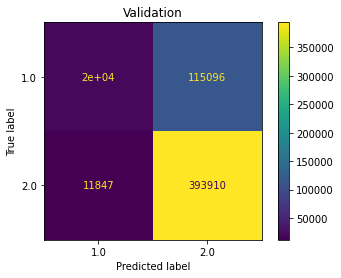

RANDOM FOREST
Accuracy:  76.55  %
Precision:  63.37  %
Recall:  15.11  %


In [9]:
# random forest validation
validationResult(clf_rfc,"RANDOM FOREST",y_test,rfc_prediction)

/home/bandala/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:429: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/bandala/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:429: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/bandala/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:429: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarn

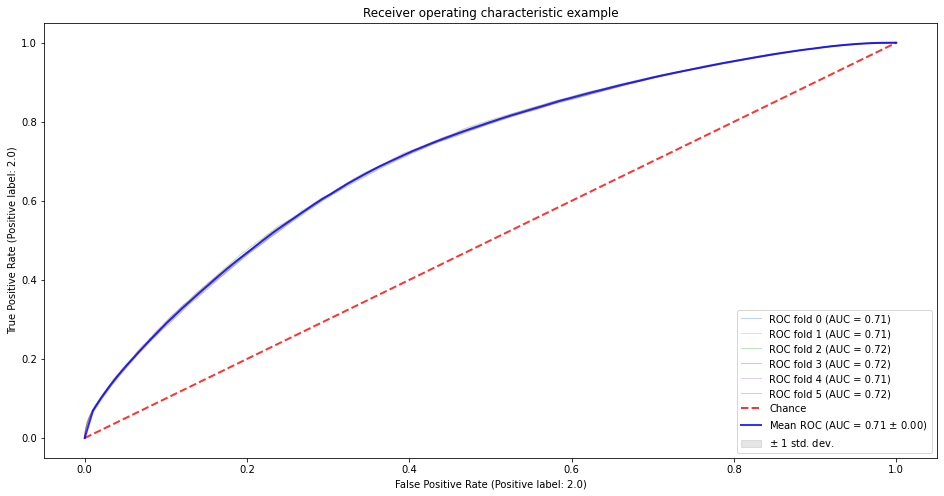

In [10]:
ROCValidation(clf_rfc,X_test,y_test)

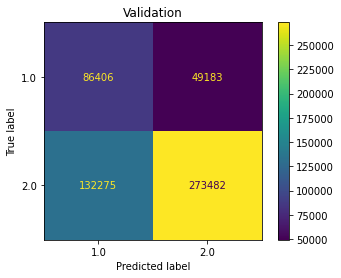

DECISION TREES CLASSIFIER
Accuracy:  66.48  %
Precision:  39.51  %
Recall:  63.73  %


In [11]:
# decision trees results
validationResult(clf_dtc,"DECISION TREES CLASSIFIER",y_test,dtc_prediction)

/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/bandala/.local/lib/pytho

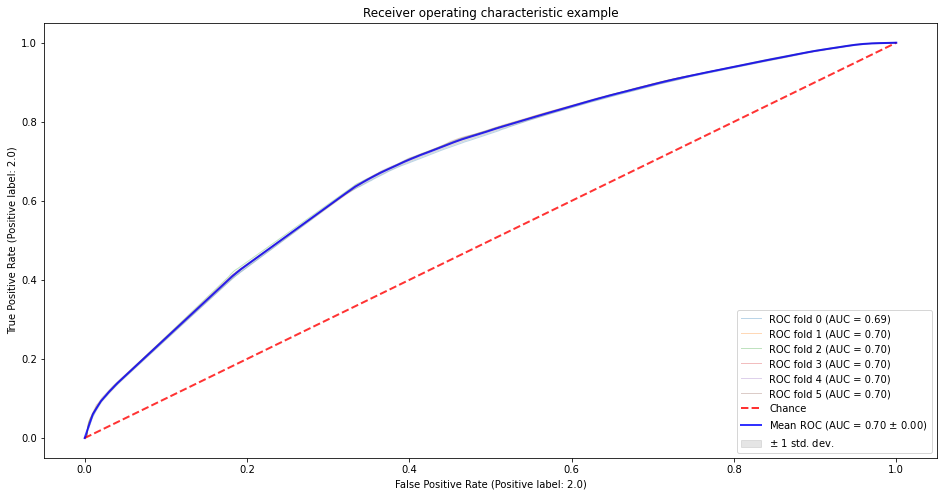

In [12]:
ROCValidation(clf_dtc,X_test,y_test)

## Features importance with Mean Decrease in Impurity

1. feature 6 (0.407623)
2. feature 5 (0.210975)
3. feature 4 (0.080320)
4. feature 2 (0.068695)
5. feature 1 (0.045400)
6. feature 3 (0.023071)
7. feature 0 (0.019370)
8. feature 13 (0.017933)
9. feature 11 (0.015313)
10. feature 18 (0.014961)
11. feature 10 (0.014866)
12. feature 12 (0.013699)
13. feature 9 (0.012188)
14. feature 16 (0.009565)


<Figure size 720x576 with 0 Axes>

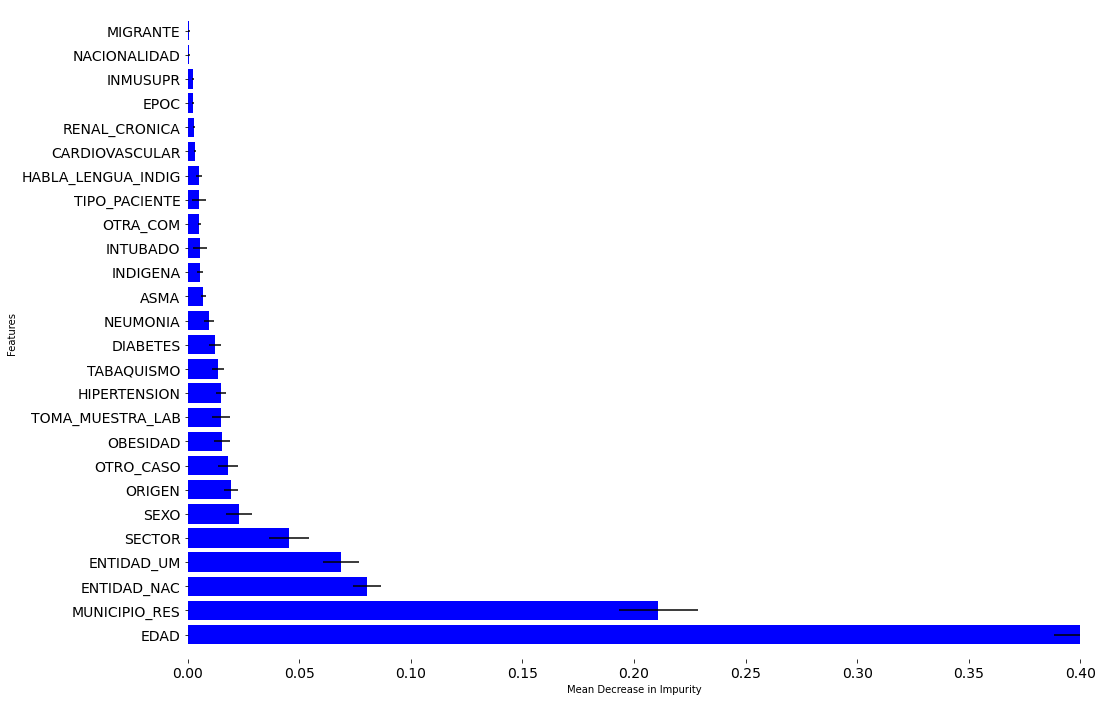

In [13]:
importances = clf_rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
#print(importances)
plt.figure(figsize=(10, 8))
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
# features names
names = X_test.columns
caract = names[indices]
for f in range(X_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    if importances[indices[f]]<0.01: break
indices=np.transpose(indices)

#Plot the feature importances of the fores
plt.figure(figsize=(16, 12))
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
#plt.title("Contribución de las Variables")
plt.ylabel("Features")
plt.xlabel("Mean Decrease in Impurity")
a = X_test.shape[1]
plt.barh(range(a), importances[indices[0:a]],
        color="b", xerr=std[indices[0:a]], align="center")
plt.yticks(range(a), caract[0:a])
plt.box(False)

plt.ylim([-1, a])
plt.xlim([0, 0.40])
plt.show()

## Training and validating a neural network with features selection

In [3]:
# select data
feature_cols = ['EDAD','MUNICIPIO_RES', 'ENTIDAD_NAC', 'SECTOR', 'SEXO', 'OTRO_CASO']

In [4]:
# multilayer perceptron model
clf_mlp = MLPClassifier(activation='sigmoid', hidden_layer_sizes=40,max_iter=200,solver='adam',random_state=1)

In [7]:
# train classifiers
with pd.read_csv(train_file, chunksize=chunksize, sep=separator, low_memory=False) as reader:
    for chunk in reader:
        # separate input/output data
        X = chunk[feature_cols]
        y = chunk['RESULTADO_ANTIGENO']
        clf_mlp.partial_fit(X,y,classes=[1,2])

In [8]:
# read validation subset
test_data = pd.read_csv(test_file)
# separate input/output data
X_test = test_data[feature_cols]
y_test = test_data['RESULTADO_ANTIGENO']

In [9]:
# multilayes perceptron predictions
mlp_prediction = clf_mlp.predict(X_test)

In [10]:
# multilayer perceptron ACC
scores = cross_val_score(clf_mlp, X_test, y_test, cv=5)
scores=scores*100
print("Multilayer perceptron ACC (Media/STD)")
print("%0.1f+/-%0.1f \n" % (scores.mean(), scores.std()))

Multilayer perceptron ACC (Media/STD)
75.0+/-0.0 



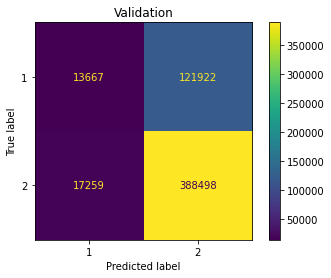

MULTILAYER PERCEPTRON
Accuracy:  74.29  %
Precision:  44.19  %
Recall:  10.08  %


In [14]:
# random forest validation
validationResult(clf_mlp,"MULTILAYER PERCEPTRON",y_test,mlp_prediction)

/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserW

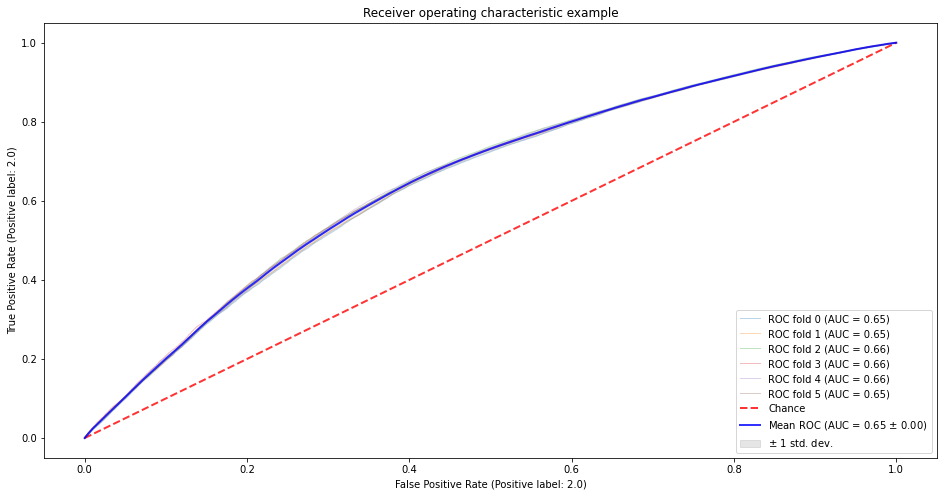

In [15]:
ROCValidation(clf_mlp,X_test,y_test)